## Методические указания по выполнению лабораторной работы №5

**Тема: Обучение модели YOLO на кастомном датасете и исследование влияния гиперпараметров на качество детекции**

**Цель работы:** Познакомиться с архитектурой YOLO на примере проверки гипотезы о релевантной метрике.

**Задачи:**

- Ознакомиться с архитектурой YOLO.
- Изучить метрики для анализа производительности модели, выбрать целевую метрику в соответствии с вариантом.
- Выбрать предметную область, сформировать гипотезу для проведения исследования.
- Собрать и проаннотировать данные, сформировать датасет.
- Провести fine-tuning предобученной модели YOLOv11 Nano/Small.
- Визуализировать и проанализировать результаты.
- На основе анализа сделать корректировку гиперпараметров/данных и провести вторую итерацию для повышения показателей.

### 1. Подготовка к обучению

#### 1.1 Метрики

Вариант 1 - Precision

Вариант 2 - Recall

Вариант 3 - F1

Вариант 4 - mAP@0.5

Вариант 5 - mAP@0.75


#### 1.2 Гипотеза

Гипотеза должна отражать характер уклона исследования с обоснованием, отталкиваясь от предметной области. *Одна лишь констатация необходимости достижения высокого значения целевой метрики не является обоснованием*.

#### 1.3 Данные

Соберите не менее 500 изображений из открытых источников. Можно пользоваться готовыми наборами данных, но важно проверить качество: разрешение изображений, качество аннотаций, баланс классов. При самостоятельном сборе данных можете воспользоваться терминальной утилитой ffmpeg для нарезки видео на кадры и любым удобным инструментом аннотирования (Roboflow, CVAT и тд).

#### 1.4 Предобработка

Примените методы аугментации к данным для расширения объема датасета для получения 1.5-2к изображений. Подготовьте данные к требуемому формату для обучающего процесса.

### 2. Обучение модели

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
cd /content/drive/MyDrive/Colab Notebooks/yolo

/content/drive/MyDrive/Colab Notebooks/yolo


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("biancaferreira/african-wildlife")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/african-wildlife


In [13]:
!cp -r /kaggle/input/african-wildlife ./

In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [7]:
# импорт пакетов
# !pip install ultralytics
from ultralytics import YOLO

import torch
# from torch import nn, optim, tensor
# import torchvision
# from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import numpy as np

import os
import shutil
import random
from glob import glob
from sklearn.model_selection import train_test_split
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса. Не используйте размер модели больше чем Small для достижения лучших показателей на стандартных гиперпараметрах (особенно imgsz)

In [ ]:
# names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck',
#         8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat',
#         16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe',
#         24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard',
#         32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket',
#         39: 'bottle',
#         40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich',
#         49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake',
#         56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop',
#         64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink',
#         72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

# cow 19 zebra 22 elephant 20


c:\Users\ttemuchin4\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 586M/586M [01:08<00:00, 8.97MB/s] 

Extracting files...


Path to dataset files: C:\Users\ttemuchin4\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2


In [8]:
# импорт модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

model = YOLO("yolo11s.pt")
model.eval()

Используемое устройство: cuda


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_runnin

In [ ]:
base_dir = "./data"
output_dir = "./dataset"
test_size = 0.2
random_seed = 42

classes = {
    "buffalo": 0,
    "elephant": 1,
    "rhino": 2,
    "zebra": 3
}

class_map = {
    0: 19,  # buffalo -> cow (19 в COCO)
    1: 20,  # elephant -> elephant (20 в COCO)
    2: -1,  # rhino -> -1
    3: 22,  # zebra -> zebra (22 в COCO)
}

def map_coco_to_yolo_class(coco_id):
    mapping = {
        19: 0,  # buffalo -> 0
        20: 1,  # elephant -> 1
        22: 2   # zebra -> 2
    }
    return mapping.get(coco_id, -1)

os.makedirs(os.path.join(output_dir, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "images", "val"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "labels", "val"), exist_ok=True)

def polygon_to_yolo_box(polygon_str):
    parts = list(map(float, polygon_str.split()))
    class_id = int(parts[0])

    if class_id not in class_map or class_map[class_id] == -1:
        return None

    polygon_points = parts[1:]
    x_coords = polygon_points[::2]
    y_coords = polygon_points[1::2]

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    return [
        class_map[class_id],
        (x_min + x_max) / 2,
        (y_min + y_max) / 2,
        x_max - x_min,
        y_max - y_min
    ]

def process_and_copy_class(class_name, class_id):
    class_dir = os.path.join(base_dir, class_name)
    images = glob(os.path.join(class_dir, "*.jpg")) + glob(os.path.join(class_dir, "*.png"))

    train_images, val_images = train_test_split(
        images, test_size=test_size, random_state=random_seed
    )

    def copy_with_prefix(src_path, dest_dir, prefix, is_label=False):
        filename = f"{prefix}_{os.path.basename(src_path)}"
        dest_path = os.path.join(dest_dir, filename)

        if is_label:
            with open(src_path, 'r') as f_in, open(dest_path, 'w') as f_out:
                for line in f_in:
                    line = line.strip()
                    if line:
                        parts = list(map(float, line.split()))
                        original_class = int(parts[0])

                        if original_class in class_map and class_map[original_class] != -1:
                            parts[0] = str(map_coco_to_yolo_class(class_map[class_id]))
                            f_out.write(" ".join(map(str, parts)) + "\n")
        else:
            shutil.copy(src_path, dest_path)

        return filename

    for img_path in train_images:
        img_name = copy_with_prefix(
            img_path,
            os.path.join(output_dir, "images", "train"),
            str(class_id)
        )

        label_path = os.path.splitext(img_path)[0] + ".txt"
        if os.path.exists(label_path):
            copy_with_prefix(
                label_path,
                os.path.join(output_dir, "labels", "train"),
                str(class_id),
                is_label=True
            )

    for img_path in val_images:
        img_name = copy_with_prefix(
            img_path,
            os.path.join(output_dir, "images", "val"),
            str(class_id)
        )

        #
        label_path = os.path.splitext(img_path)[0] + ".txt"
        if os.path.exists(label_path):
            copy_with_prefix(
                label_path,
                os.path.join(output_dir, "labels", "val"),
                str(class_id),
                is_label=True
            )

for class_name, class_id in classes.items():
    print(f"Processing class: {class_name} (ID: {class_id})")
    process_and_copy_class(class_name, class_id)

print("\nDataset preparation completed!")
print(f"Train/Val split created with test_size={test_size}")
print(f"Output directory: {output_dir}")

Processing class: buffalo (ID: 0)
Processing class: elephant (ID: 1)
Processing class: rhino (ID: 2)
Processing class: zebra (ID: 3)

Dataset preparation completed!
Train/Val split created with test_size=0.2
Output directory: ./dataset



Class distribution:

Train set:
buffalo (0): 462 instances
elephant (1): 589 instances
zebra (2): 632 instances

Val set:
buffalo (0): 100 instances
elephant (1): 162 instances
zebra (2): 170 instances

Class distribution:

Train set:
buffalo (0): 462 instances
elephant (1): 589 instances
zebra (2): 632 instances

Val set:
buffalo (0): 100 instances
elephant (1): 162 instances
zebra (2): 170 instances

0_370.jpg


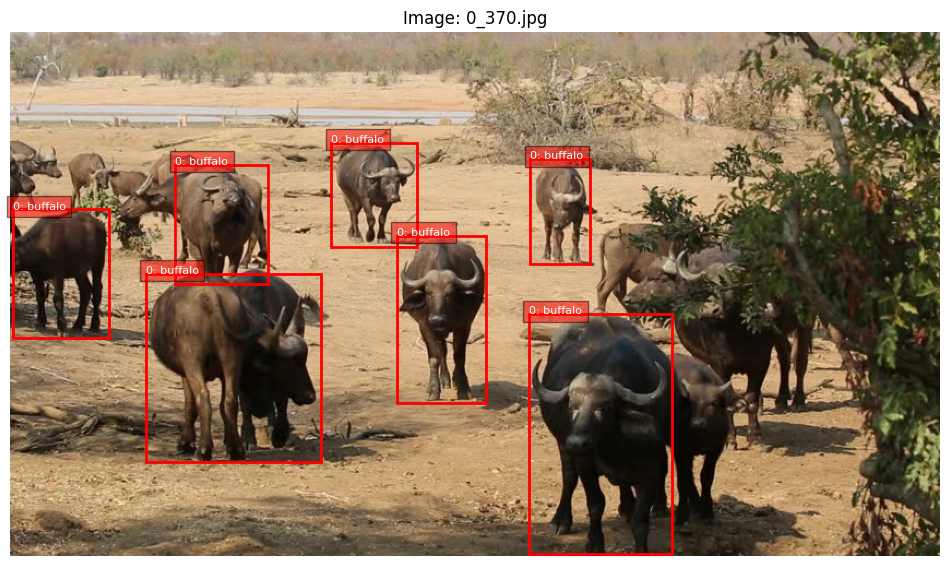

In [11]:
def check_distribution():
    print("\nClass distribution:")
    for split in ["train", "val"]:
        labels_dir = os.path.join(output_dir, "labels", split)
        counts = [0, 0, 0]  # для 0, 1, 2

        for label_file in os.listdir(labels_dir):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        if 0 <= class_id <= 2:
                            counts[class_id] += 1

        print(f"\n{split.capitalize()} set:")
        print(f"buffalo (0): {counts[0]} instances")
        print(f"elephant (1): {counts[1]} instances")
        print(f"zebra (2): {counts[2]} instances")

check_distribution()

def plot_example(image_path, label_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img)
    yolo_names = ['buffalo', 'elephant', 'zebra']

    with open(label_path) as f:
        for line in f:
            if line.strip():
                parts = list(map(float, line.split()))
                class_id = int(parts[0])  # Теперь это 0, 1 или 2

                coco_id, x_center, y_center, width, height = parts[:5]
                coco_id = int(coco_id)

                # YOLO-формат в координаты
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)

                # bounding box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    fill=False, color='red', linewidth=2)
                ax.add_patch(rect)

                plt.text(x1, y1, f"{class_id}: {yolo_names[class_id]}",
                    color='white', fontsize=8,
                    bbox=dict(facecolor='red', alpha=0.5))

    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

check_distribution()

train_images = glob(os.path.join(output_dir, "images", "train", "*"))
if train_images:
    example_image = train_images[2]
    example_label = os.path.join(
        output_dir, "labels", "train",
        os.path.splitext(os.path.basename(example_image))[0] + ".txt"
    )

    print(f"\n{os.path.basename(example_image)}")
    plot_example(example_image, example_label)


In [14]:
results = model.train(
    data="data.yaml",
    epochs=8,
    imgsz=1024,
    device="0"
)

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=8, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False,

100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1    820569  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
YOLO11s summary: 181 layers, 9,428,953 parameters, 9,428,937 gradients, 21.6 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 70.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 108.4±132.3 MB/s, size: 451.3 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/yolo/dataset/labels/train... 1200 images, 294 backgrounds, 6 corrupt: 100%|██████████| 1200/1200 [00:13<00:00, 88.08it/s] 

train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/0_054.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_037.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_256.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_375.jpg: ignoring corrupt image/label: negative label values [         -1          -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_377.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_378.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_379.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /conte

train: New cache created: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 44.5±47.7 MB/s, size: 154.7 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/yolo/dataset/labels/val... 301 images, 74 backgrounds, 1 corrupt: 100%|██████████| 301/301 [00:04<00:00, 72.90it/s]

val: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/val/2_033.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/val/2_238.jpg: ignoring corrupt image/label: negative label values [         -1          -1]


val: New cache created: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/labels/val.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8      9.87G     0.9704      2.479      1.467         27       1024: 100%|██████████| 75/75 [01:06<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

                   all        300        432      0.492      0.465      0.364      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8      9.91G      1.157      1.489      1.599         22       1024: 100%|██████████| 75/75 [01:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


                   all        300        432      0.572      0.258      0.275      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8      9.91G      1.209      1.406      1.655         39       1024: 100%|██████████| 75/75 [01:06<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

                   all        300        432      0.552      0.484      0.485      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8      9.93G      1.161      1.288      1.609         21       1024: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        300        432      0.494      0.607      0.596      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8      9.86G      1.086      1.226      1.569         33       1024: 100%|██████████| 75/75 [01:06<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        300        432      0.708      0.713       0.76      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8      9.91G     0.9942      1.085      1.488         37       1024: 100%|██████████| 75/75 [01:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        300        432      0.751      0.737      0.797      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8      9.88G     0.9264     0.9612      1.429         55       1024: 100%|██████████| 75/75 [01:05<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        300        432      0.822      0.794      0.874      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8      9.91G     0.8516     0.8336      1.363         37       1024: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        300        432      0.858      0.803      0.895      0.692



8 epochs completed in 0.166 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 19.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


                   all        300        432      0.858      0.803      0.895      0.692
               buffalo         75        100      0.794       0.88      0.925      0.744
              elephant         75        162      0.892      0.728      0.874      0.666
                 zebra         76        170      0.889      0.801      0.887      0.666
Speed: 0.6ms preprocess, 8.8ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/train3


In [16]:
precision = results.box.p
recall = results.box.r
f1_score = 2 * (precision * recall) / (precision + recall + 1e-16)

print(f"Recall: {results.box.r}")
print(f"Precision: {results.box.p}")
print(f"F1-Score: {f1_score}")

Recall: [       0.88      0.7284     0.80082]
Precision: [    0.79371     0.89225     0.88899]
F1-Score: [    0.83463     0.80204     0.84261]


In [17]:
model.save('MODEL1.pt')

In [18]:
from google.colab import files
files.download('MODEL1.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# исследование
from ultralytics import YOLO
model = YOLO("yolo11s.pt")
model = model.load("MODEL1.pt")

Transferred 493/499 items from pretrained weights


In [20]:
torch.cuda.empty_cache()

In [ ]:
results = model.train(
    data="data.yaml",
    imgsz=900, #????
    pretrained=True,
    epochs=14,    # Доп эпохи
    conf=0.1,     # less threshold ???
    iou=0.4,
    box=0.7,      # больше влияния координат бокса
    cls=0.3,      # меньше штрафа за ошибки класса
    dfl=1.5,
    lr0=0.001,    # подключаем оптимизаторы крутыее ???
    optimizer='Adam',
    weight_decay=0.0001
)

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.7, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.3, conf=0.1, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=14, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=900, int8=False, iou=0.4, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False,

train: Scanning /content/drive/MyDrive/Colab Notebooks/yolo/dataset/labels/train.cache... 1200 images, 294 backgrounds, 6 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/0_054.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_037.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_256.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_375.jpg: ignoring corrupt image/label: negative label values [         -1          -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_377.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_378.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/train/2_379.jpg: ignoring corrupt image/label: negative label values [         -1]
train: /conte

val: Fast image access ✅ (ping: 5.1±2.9 ms, read: 26.0±19.4 MB/s, size: 154.7 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/yolo/dataset/labels/val.cache... 301 images, 74 backgrounds, 1 corrupt: 100%|██████████| 301/301 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/val/2_033.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Colab Notebooks/yolo/dataset/images/val/2_238.jpg: ignoring corrupt image/label: negative label values [         -1          -1]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0001), 87 bias(decay=0.0)
Image sizes 928 train, 928 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 14 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/14      8.73G    0.08468     0.8773      1.364         27        928: 100%|██████████| 75/75 [01:01<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

                   all        300        432      0.795      0.753      0.827      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/14      8.69G    0.08864     0.5695       1.37         22        928: 100%|██████████| 75/75 [01:00<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        300        432       0.87      0.719      0.831      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/14      8.69G    0.09018     0.5784      1.395         39        928: 100%|██████████| 75/75 [01:05<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        300        432      0.798      0.808      0.861      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/14       8.7G    0.08815      0.563      1.372         21        928: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        300        432      0.823      0.815       0.87      0.629


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/14      8.66G    0.09028     0.5729       1.47         13        928: 100%|██████████| 75/75 [01:08<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

                   all        300        432      0.811      0.701      0.783      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/14      8.64G    0.08947     0.5413      1.456         14        928: 100%|██████████| 75/75 [01:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        432      0.781      0.709      0.783       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/14      8.66G    0.08524     0.4985      1.405         17        928: 100%|██████████| 75/75 [01:01<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        300        432      0.862      0.799       0.87       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/14      8.65G    0.08062     0.4712      1.381         18        928: 100%|██████████| 75/75 [01:01<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        300        432      0.897      0.818      0.902      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/14      8.67G    0.07763     0.4422      1.355         12        928: 100%|██████████| 75/75 [01:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        300        432      0.857      0.839       0.91      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/14      8.64G    0.07376     0.3958      1.299          8        928: 100%|██████████| 75/75 [00:59<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

                   all        300        432      0.951      0.819      0.917      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/14      8.74G    0.06819     0.3603      1.247         19        928: 100%|██████████| 75/75 [01:01<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        300        432      0.878      0.859      0.914      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/14       8.7G    0.06626     0.3499      1.224         11        928: 100%|██████████| 75/75 [00:56<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        300        432      0.927      0.866      0.932      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/14       8.7G    0.06209     0.3197        1.2         14        928: 100%|██████████| 75/75 [00:58<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        300        432      0.916       0.88      0.938      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/14      8.63G    0.05925      0.298      1.167         11        928: 100%|██████████| 75/75 [00:55<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        300        432      0.939      0.857      0.935      0.777



14 epochs completed in 0.273 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 19.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


                   all        300        432      0.939      0.857      0.935      0.778
               buffalo         75        100       0.95       0.95      0.977      0.842
              elephant         75        162      0.926      0.768      0.898      0.737
                 zebra         76        170      0.941      0.853      0.929      0.754
Speed: 0.4ms preprocess, 7.1ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to runs/detect/train4


In [24]:
precision = results.box.p
recall = results.box.r
f1_score = 2 * (precision * recall) / (precision + recall + 1e-16)

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1_score}")

Recall: [       0.95     0.76765     0.85294]
Precision: [    0.94983     0.92557     0.94052]
F1-Score: [    0.94992     0.83924     0.89459]


In [25]:
model.save('MODEL2.pt')

from google.colab import files
files.download('MODEL2.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
#
t1 = model("./dataset/images/val/0_087.jpg")
t1[0].show()
t2 = model("./dataset/images/val/1_314.jpg")
t2[0].show()
t3 = model("./dataset/images/val/3_131.jpg")
t3[0].show()

NameError: name 'model' is not defined

#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет в проект и выполните трансформацию данных (при использовании Roboflow трансформация выполняется на этапе предобработки):

#### 2.4 Обучение, оценка модели и визуализация результатов

Проведите обучение модели, проанализируйте кривые обучения, метрики и тестовые данные. Сделайте вывод и корректироваки для достижения лучших показателей

In [ ]:
# обучение, оценка, визуализация


#### 2.5 Вторая итерация

Проведите процедуры для достижения высоких показателей (корректировка данных/гиперпараметров), сделайте вывод


In [ ]:
# исследование
